In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

### Setup the notebook.

In [3]:
import h5py
import math
testNames=[
           "first_order_birth_death_1",
          ]
test_names_bash_list=" ".join(testNames)
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [4]:
%%bash
rm -rf tmp && mkdir tmp

### Execute the simulations.

In [5]:
%%bash -s "$test_names_bash_list"
sbmlFilename="first_order_birth_death.sbml"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    rm -f ${outputFilename}* && lm_sbml_import ${outputFilename} ${sbmlFilename} > ${outputFilename}.import.log
    
    if [[ ${testName} == *_1 ]]; then
        lmes -r 1-100 -f ${outputFilename},${testName}.properties -c 4 -nr -sw -swp 3 -swf ${testName}.dat -sl lm::cme::NextReactionSolver -pf 2 -rnp > ${outputFilename}.simulate.log
    fi
done;
echo "Finished."

Finished.


### Spot check some simulations.

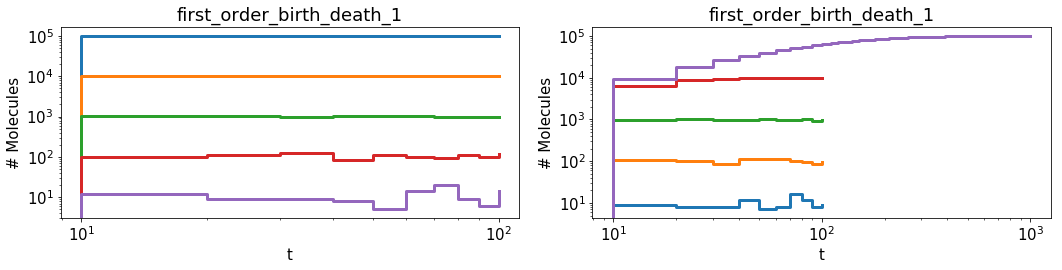

In [6]:
# Plot the time series for a single replicate.
for i,testName in enumerate(testNames):
    testOutputFilename="tmp/%s.lm"%(testName)
    fp = h5py.File(testOutputFilename, "r")
    cols=2
    rows=len(testNames)
    if rows*cols < len(testNames): rows += 1
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,4*rows)})
    subplot(rows,cols,i*cols+1)
    for paramName in ("P0","P1","P2","P3","P4"):
        for replicate in (1,):
            counts=np.array(fp["/Sweep/%s/Simulations/%07d/SpeciesCounts"%(paramName,replicate)], dtype=double)
            times=np.array(fp["/Sweep/%s/Simulations/%07d/SpeciesCountTimes"%(paramName,replicate)], dtype=double)
            step(times,counts[:,0], **stepStyles)
    xlabel('t'); xscale('log'); ylabel('# Molecules'); yscale('log'); title("%s"%(testName))
    subplot(rows,cols,i*cols+2)
    for paramName in ("P5","P6","P7","P8","P9"):
        for replicate in (1,):
            counts=np.array(fp["/Sweep/%s/Simulations/%07d/SpeciesCounts"%(paramName,replicate)], dtype=double)
            times=np.array(fp["/Sweep/%s/Simulations/%07d/SpeciesCountTimes"%(paramName,replicate)], dtype=double)
            step(times,counts[:,0], **stepStyles)
    xlabel('t'); xscale('log'); ylabel('# Molecules'); yscale('log'); title("%s"%(testName))
    fp.close()
plt.tight_layout()
pass

### Define the tests.

In [7]:
def test_first_order_birth_death_1(testOutputFilename):
    fp = h5py.File(testOutputFilename, "r")
    paramNames = ("P0","P1","P2","P3","P4","P5","P6","P7","P8","P9")
    paramMeans = (1e5,1e4,1e3,1e2,1e1,1e1,1e2,1e3,1e4,1e5)
    paramTimes = (1e2,1e2,1e2,1e2,1e2,1e2,1e2,1e2,1e2,1e3)
    sweeps=fp["/Sweep"].keys()
    if len(sweeps) != len(paramNames): raise Exception("incorrect number of parameters in sweep",value)
    for paramIndex in range(len(paramNames)):
        replicates=fp["/Sweep/%s/Simulations"%(paramNames[paramIndex])].keys()
        if len(replicates) != 100: raise Exception("incorrect number of replicates in parameter",paramNames[paramIndex])
        k=0
        mSim=None
        vSim=None
        times=None
        for replicate in replicates:
            times = np.array(fp["/Sweep/%s/Simulations/%s/SpeciesCountTimes"%(paramNames[paramIndex],replicate)], dtype=double)
            counts = np.array(fp["/Sweep/%s/Simulations/%s/SpeciesCounts"%(paramNames[paramIndex],replicate)], dtype=double)
            if not isclose(times[-1], paramTimes[paramIndex]): raise Exception("incorrect max time for parameter",paramNames[paramIndex])
            if mSim is None:
                k += 1
                mSim = counts
                vSim = np.zeros(counts.shape, dtype=double)
            else:
                k += 1
                mSim = mSim + (counts-mSim)/k
                vSim = vSim + (counts-mSim)*(counts-mSim)
        vSim /= float((k-1))
        
    
        # Plot the accuracy of the mean and variance.
        matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3)})
        ax=plt.subplot(1,2,1)
        plt.plot(times,mSim, **plotStyles)
        ax.set_yscale('log'); xlabel('t'); ax.set_xscale('log'); ylabel('E{X(t)}'); title("%s"%(testOutputFilename))
        ax=plt.subplot(1,2,2)
        plt.plot(times,vSim, **plotStyles)
        ax.set_yscale('log'); xlabel('t'); ax.set_xscale('log'); ylabel('Var{X(t)}'); title("%s"%(testOutputFilename))

        value = np.mean(mSim[len(mSim)//2:])
        if not isclose(value,paramMeans[paramIndex],1e-2): raise Exception("incorrect value for mean",value)
        value = np.mean(vSim[len(mSim)//2:])
        if not isclose(value,paramMeans[paramIndex],2e-1): raise Exception("incorrect value for variance",value)
            
    fp.close()            

### Run the tests.

/usr/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[first_order_birth_death_1]                                  : passed.


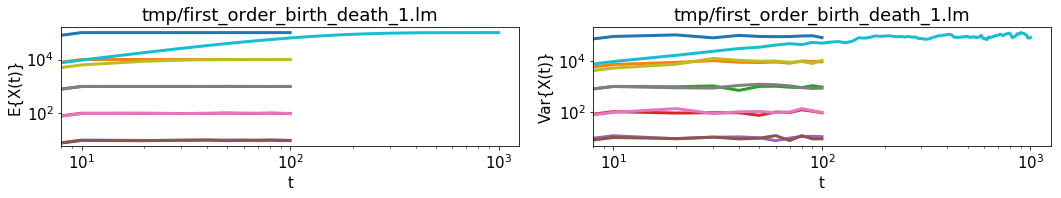

In [8]:
testMethods = {
               "first_order_birth_death_1": test_first_order_birth_death_1,
              }
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5*len(testNames))})
i=1
for testName in testNames:
    try:
        testOutputFilename="tmp/%s.lm"%(testName)
        testMethods[testName](testOutputFilename)
    except Exception as e:
        print "%-60s : FAILED with:"%("["+testName+"]"),e
    except:
        print "%-60s : FAILED with: Unknown exception"%("["+testName+"]")
    else:
        print "%-60s : passed."%("["+testName+"]")
    plt.tight_layout()
    plt.show()
pass

In [9]:
%%bash
rm -rf tmp